<center> Автор материала: Толстошеева Татьяна (@tsheeva)

# <center> Анализ мировых продаж компьютерных игр для магазина "Стримчик" </center>

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед нами данные до 2016 года. Мы планируем кампанию на 2017-й.

## Чтение и описание данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats as st 
import missingno as msno

In [4]:
# загружаем датасет
data = pd.read_csv('/datasets/games.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
# распечатаем его размер и первые 5 строк
print(data.shape)
display(data.head())

(16715, 11)


Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

Описание данных: 
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

Мы видим:
- неудобное написание названий столбцов (присутствуют заглавные буквы),
- пропуски,
- необходимость изменить типы данных

## Предобработка данных

### Названия столбцов

In [7]:
# приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

### Работа с пропусками

In [8]:
# посчитаем недостающие значения
data.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

<AxesSubplot:>

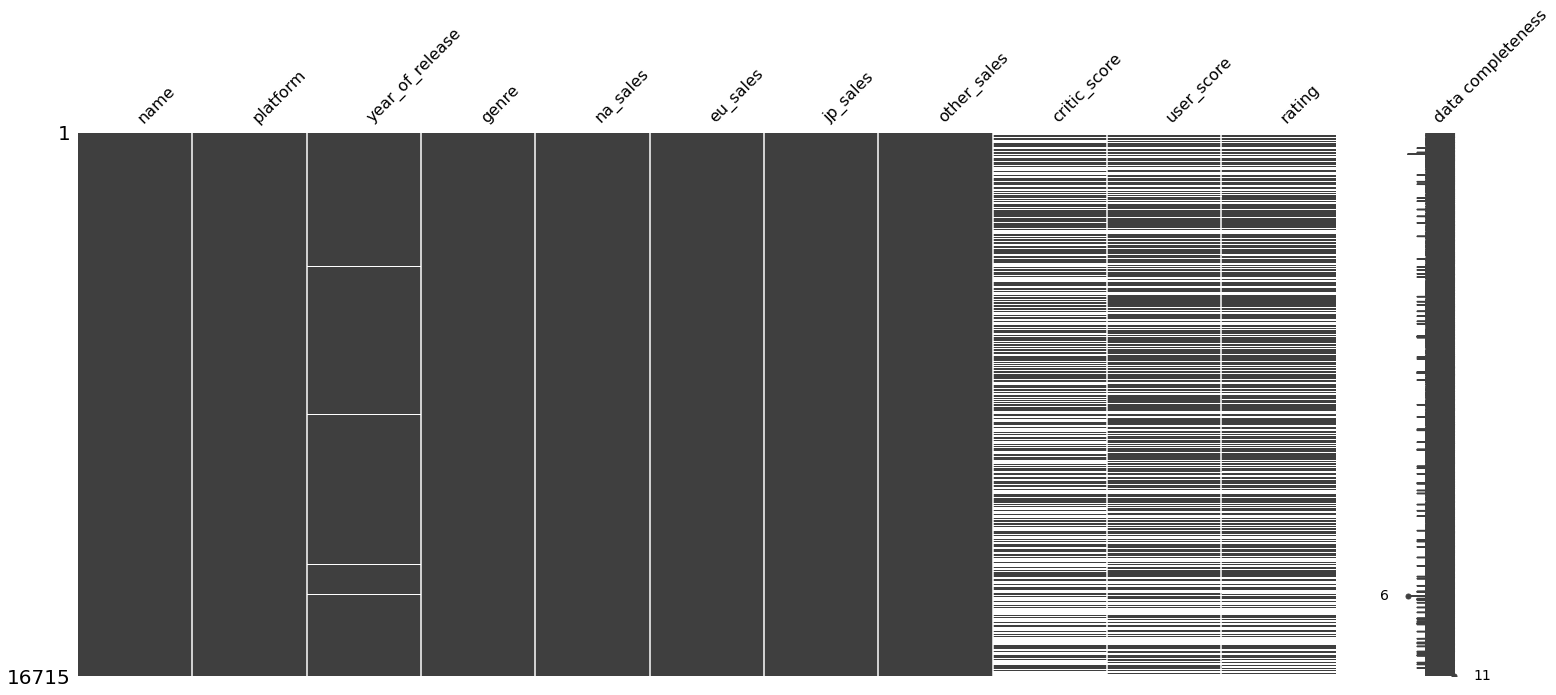

In [9]:
msno.matrix(data, labels=True)

<AxesSubplot:>

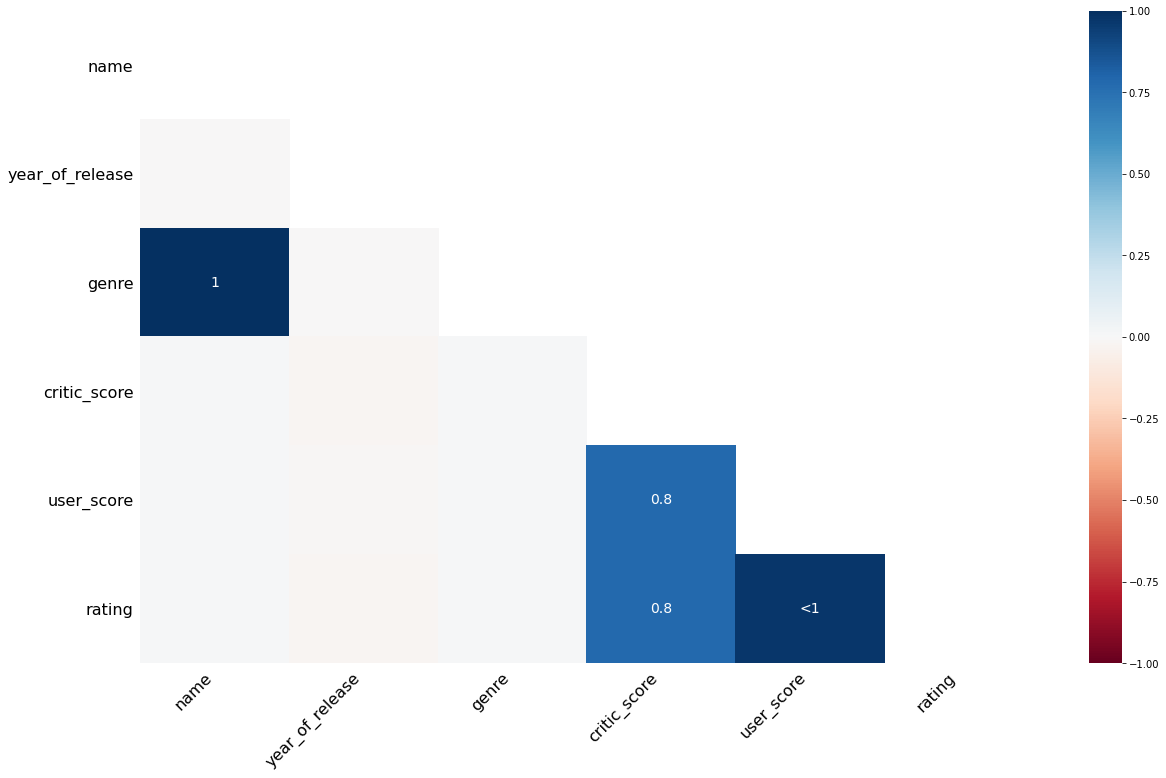

In [10]:
msno.heatmap(data)

В названии игр и жанре есть 2 пропуска. Судя по тепловой карте - они связаны. 

In [11]:
data[data['name'].isnull()]

name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN

Да, пропуски связаны. Заполнить их мы не сможем - удалим их из датасета:

In [12]:
data = data.dropna(subset=['name']).reset_index(drop=True)

#### Year of release

В данных 269 пропусков в годе релиза. Проверим, какую долю они занимают в датасете:

In [13]:
display('процент пропусков годе релиза {}%'.
        format(round(data['year_of_release'].isna().sum() / len(data['year_of_release']) * 100, 2))
              )

'процент пропусков годе релиза 1.61%'

Мы не сможем заполнить пропуски медианой или средним значением. Так как их процент незначителен для дальнейшего исследования, удалим эти игры. 

In [14]:
data = data.dropna(subset=['year_of_release']).reset_index(drop=True)
data[data['year_of_release'].isnull()]

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []

#### Rating

Рейтинг ESRB - Северо-американская классификация компьютерных игр. 

- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»
- K-A - старый вариант маркировки E (for everyone)


In [15]:
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Игр из рейтингов EC, K-A, AO, RP - очень мало. Добавим их в более крупные группы, недостающие значения и RP заменим на 'Unknown'.

In [16]:
data.loc[data['rating'].isin(['K-A']), 'rating'] = 'E'
data.loc[data['rating'] == 'AO', 'rating'] = 'M'
data.loc[data.loc[:,'rating'].isnull(),'rating'] = 'Unknown'
data.loc[data['rating'] == 'RP', 'rating'] = 'Unknown'
data.loc[data['rating'] == 'EC', 'rating'] = 'E'

data.rating.value_counts()

Unknown    6677
E          3932
T          2905
M          1537
E10+       1393
Name: rating, dtype: int64

Мы укрупнили группы по возрастному рейтингу. Посмотрим, одинаковые ли рейтинги у одних и тех же игр, выпущенных в один год:

In [17]:
data[data.duplicated(subset=['name', 'year_of_release'])].sort_values(['name','year_of_release'])

name platform  year_of_release     genre  \
3810           Frozen: Olaf's Quest       DS           2013.0  Platform   
1765         007: Quantum of Solace      PS3           2008.0    Action   
3078         007: Quantum of Solace      Wii           2008.0    Action   
4412         007: Quantum of Solace      PS2           2008.0    Action   
9359         007: Quantum of Solace       DS           2008.0    Action   
...                             ...      ...              ...       ...   
3258      pro evolution soccer 2011     X360           2010.0    Sports   
4599      pro evolution soccer 2011      PS2           2010.0    Sports   
7038      pro evolution soccer 2011      Wii           2010.0    Sports   
12450     pro evolution soccer 2011       PC           2010.0    Sports   
15365  uDraw Studio: Instant Artist     X360           2011.0      Misc   

       na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
3810       0.21      0.26      0.00         0.04           NaN        NaN   
1765       0.43      0.51      0.02         0.19          65.0        6.6   
3078       0.29      0.28      0.01         0.07          54.0        7.5   
4412       0.17      0.00      0.00         0.26           NaN        NaN   
9359       0.11      0.01      0.00         0.01          65.0        tbd   
...         ...       ...       ...          ...           ...        ...   
3258       0.09      0.44      0.00         0.07          79.0        5.9   
4599       0.04      0.21      0.05         0.11           NaN        6.7   
7038       0.07      0.10      0.03         0.02          78.0        5.4   
12450      0.00      0.05      0.00         0.01          79.0        NaN   
15365      0.01      0.01      0.00         0.00          54.0        5.7   

        rating  
3810   Unknown  
1765         T  
3078         T  
4412   Unknown  
9359         T  
...        ...  
3258         E  
4599         E  
7038         E  
12450  Unknown  
15365        E  

[4249 rows x 11 columns]

Уже видно, когда мы группируем игры по названию и году выпуска, встречаются и недостающие значения только у одной игры (например в "007: Quantum of Solace для PS2"), и у всех игр в группе ("Frozen: Olaf's Quest"). В первом случае мы можем заполнить недостающие значения, во втором - нет.

In [18]:
# группируем данные по названию и году выпуска и находим рейтинг
rating = data.groupby(['name', 'year_of_release'],as_index=False).agg({'rating': 'min'})
rating = rating.rename(columns={'rating' : 'new_rating'})
rating.head(10)

name  year_of_release new_rating
0                           Beyblade Burst           2016.0    Unknown
1                        Fire Emblem Fates           2015.0    Unknown
2                     Frozen: Olaf's Quest           2013.0    Unknown
3               Haikyu!! Cross Team Match!           2016.0    Unknown
4                        Tales of Xillia 2           2012.0          T
5                              '98 Koshien           1998.0    Unknown
6               .hack//G.U. Vol.1//Rebirth           2006.0    Unknown
7             .hack//G.U. Vol.2//Reminisce           2006.0    Unknown
8  .hack//G.U. Vol.2//Reminisce (jp sales)           2006.0    Unknown
9            .hack//G.U. Vol.3//Redemption           2007.0    Unknown

Мы заметили в названиях 'jp sales'. Возможно, в таких строках содержится информация о продажах в конкретных регионах. Изучим это позже.

In [19]:
# соединяем две таблицы, и заполняем недостающие значения
data = data.merge(rating, how='left',
                  left_on=['name', 'year_of_release'],
                  right_on=['name', 'year_of_release'])
data.loc[data['rating'] == 'Unknown', 'rating'] = data['new_rating']
# лишний столбец удаляем
data = data.drop('new_rating', axis=1)

In [20]:
data.rating.value_counts()

Unknown    6468
E          4023
T          2961
M          1569
E10+       1423
Name: rating, dtype: int64

Рассмотрим подробнее оставшиеся пропуски. 

Организация ESRB появилась в 1994 году, при этом, не всем играм сразу начали присваивать рейтинг. Посмотрим, что было с рейтингами до 2000 года:

In [21]:
data[data['year_of_release'] < 2000]['rating'].value_counts()

Unknown    1866
T            48
E            44
M            15
E10+          1
Name: rating, dtype: int64

Получается, что часть пропусков в рейтинге связаны с тем, что на момент релиза игры ERSB еще не появилась. 

Итог: мы укрупнили значения рейтинга и из 8 групп сделали 5. Там, где это было возможно - заполнили пропуски (около 300), остальные заменили значениями "Unknown".

Организация ESRB начала работу в 1994, поэтому отсутствие значений у игр, релиз которых произошел близко к этой дате - вполне объясним. 

#### Sales

Ранее мы заметили, что в некоторых названиях содержится информация о продажах в конкретных регионах. Изучим эти игры:

In [22]:
display(data[data['name'].str.contains('sale')].sort_values('name').head(8))
data[data['name'].str.contains('sale')].info()

name platform  \
8461             .hack//G.U. Vol.2//Reminisce (jp sales)      PS2   
9104                       Ape Escape Academy (jp sales)      PSP   
14777             Battlefield 2: Modern Combat(JP sales)      PS2   
10505                      Bleach: Dark Souls (JP sales)       DS   
15830                               Bomberman (jp sales)      PSP   
10019               Brave Story: New Traveler (US sales)      PSP   
13230              Brave Story: New Traveller (jp sales)      PSP   
7714   Chou-Kuukan Night Pro Yakyuu King (weekly JP s...      N64   

       year_of_release         genre  na_sales  eu_sales  jp_sales  \
8461            2006.0  Role-Playing      0.00       0.0      0.16   
9104            2004.0          Misc      0.00       0.0      0.13   
14777           2005.0       Shooter      0.00       0.0      0.02   
10505           2007.0      Fighting      0.00       0.0      0.10   
15830           2006.0        Puzzle      0.00       0.0      0.01   
10019           2006.0  Role-Playing      0.11       0.0      0.00   
13230           2006.0  Role-Playing      0.00       0.0      0.05   
7714            1996.0        Sports      0.00       0.0      0.19   

       other_sales  critic_score user_score   rating  
8461           0.0           NaN        NaN  Unknown  
9104           0.0           NaN        NaN  Unknown  
14777          0.0           NaN        NaN  Unknown  
10505          0.0           NaN        NaN  Unknown  
15830          0.0           NaN        NaN  Unknown  
10019          0.0           NaN        NaN  Unknown  
13230          0.0           NaN        NaN  Unknown  
7714           0.0           NaN        NaN  Unknown

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 778 to 16414
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             142 non-null    object 
 1   platform         142 non-null    object 
 2   year_of_release  142 non-null    float64
 3   genre            142 non-null    object 
 4   na_sales         142 non-null    float64
 5   eu_sales         142 non-null    float64
 6   jp_sales         142 non-null    float64
 7   other_sales      142 non-null    float64
 8   critic_score     0 non-null      float64
 9   user_score       0 non-null      object 
 10  rating           142 non-null    object 
dtypes: float64(6), object(5)
memory usage: 13.3+ KB


In [23]:
data[data['jp_sales'] == 0.0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10300 entries, 61 to 16442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             10300 non-null  object 
 1   platform         10300 non-null  object 
 2   year_of_release  10300 non-null  float64
 3   genre            10300 non-null  object 
 4   na_sales         10300 non-null  float64
 5   eu_sales         10300 non-null  float64
 6   jp_sales         10300 non-null  float64
 7   other_sales      10300 non-null  float64
 8   critic_score     5904 non-null   float64
 9   user_score       7653 non-null   object 
 10  rating           10300 non-null  object 
dtypes: float64(6), object(5)
memory usage: 965.6+ KB


Действительно, в названиях указываются страны, где происходили продажи - это неявные дубликаты. Так как их всего 147, и в масштабах всего датафрейма они не дают ощутимого веса, оставим их без изменений. 

### Преобразование типов данных

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 2.0+ MB


В данных содержится информация, которую можно отнести к категориальным значениям (genre, platform, rating), проверим их и заменим тип.

In [25]:
data['genre'].value_counts()

Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
Name: genre, dtype: int64

In [26]:
data['platform'].value_counts().sort_values()

PCFX       1
GG         1
TG16       2
3DO        3
SCD        6
WS         6
NG        12
GEN       27
DC        52
GB        97
NES       98
2600     116
WiiU     147
SAT      173
SNES     239
XOne     247
N64      316
PS4      392
PSV      429
3DS      512
GC       542
XB       803
GBA      811
PC       957
PS      1190
PSP     1193
X360    1232
Wii     1286
PS3     1306
DS      2121
PS2     2127
Name: platform, dtype: int64

In [27]:
data['platform'] = data['platform'].astype('category')
data['genre'] = data['genre'].astype('category')
data['rating'] = data['rating'].astype('category')

In [28]:
# приведем год к целочисленным значениям
data['year_of_release'] = data['year_of_release'].astype('int')

In [29]:
# проверим user_score прежде чем изменить тип данных
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В значениях встретился "TBD" - аббревиатура от английского To Be Determined (будет определено). То есть данные по оценке пользователей еще не готова. Заменим на NAN для удобства работы и преобразуем значения в тип float.

In [30]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [31]:
data['user_score'] = data['user_score'].astype('float')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16444 non-null  category
 2   year_of_release  16444 non-null  int64   
 3   genre            16444 non-null  category
 4   na_sales         16444 non-null  float64 
 5   eu_sales         16444 non-null  float64 
 6   jp_sales         16444 non-null  float64 
 7   other_sales      16444 non-null  float64 
 8   critic_score     7983 non-null   float64 
 9   user_score       7463 non-null   float64 
 10  rating           16444 non-null  category
dtypes: category(3), float64(6), int64(1), object(1)
memory usage: 1.7+ MB


### Дубликаты

In [33]:
data.duplicated().sum()

0

Явных дубликатов нет. Проверим дубликаты, сгруппировав данные по названию, году и платформе:

In [34]:
data[data.duplicated(subset=['name', 'platform', 'year_of_release'])]

name platform  year_of_release   genre  na_sales  eu_sales  \
15969  Madden NFL 13      PS3             2012  Sports       0.0      0.01   

       jp_sales  other_sales  critic_score  user_score rating  
15969       0.0          0.0          83.0         5.5      E

In [35]:
# удалим дубликат
data = data.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first')

In [36]:
# проверим игру после удаления дубликата
data[data['name'] =="Madden NFL 13"].sort_values('year_of_release')

name platform  year_of_release   genre  na_sales  eu_sales  \
503   Madden NFL 13     X360             2012  Sports      2.53      0.15   
600   Madden NFL 13      PS3             2012  Sports      2.11      0.22   
3933  Madden NFL 13      Wii             2012  Sports      0.47      0.00   
5800  Madden NFL 13      PSV             2012  Sports      0.28      0.00   
6956  Madden NFL 13     WiiU             2012  Sports      0.21      0.00   

      jp_sales  other_sales  critic_score  user_score rating  
503        0.0         0.17          81.0         5.8      E  
600        0.0         0.23          83.0         5.5      E  
3933       0.0         0.03           NaN         7.3      E  
5800       0.0         0.02          63.0         7.3      E  
6956       0.0         0.02          75.0         6.7      E

### Общие продажи

In [37]:
# добавим столбец с информацией о всех продажах
data['total_sales'] = data.apply(lambda row: sum(row[['na_sales','eu_sales','jp_sales','other_sales']]),axis =1)

In [38]:
data.head(5)

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score   rating  \
0     28.96      3.77         8.45          76.0         8.0        E   
1      3.58      6.81         0.77           NaN         NaN  Unknown   
2     12.76      3.79         3.29          82.0         8.3        E   
3     10.93      3.28         2.95          80.0         8.0        E   
4      8.89     10.22         1.00           NaN         NaN  Unknown   

   total_sales  
0        82.54  
1        40.24  
2        35.52  
3        32.77  
4        31.38

### Вывод

- Мы исправили названия столбцов и привели их к нижнему регистру;
- Обработали пропуски: 
    - укрупнили значения рейтинга и из 8 групп сделали 5. Там, где это было возможно - заполнили пропуски (около 300), остальные заменили значениями "Unknown";
    - заполнили 123 пропуска в годе релиза из аналогичных игр. Остальные пропуски мы заполнить не смогли и удалили эти строки;
- Преобразовали типы данных:
    - 'name', 'platform', 'genre', 'rating' изменили на categoty,
    - 'year_of_release' на int64, 
    - 'user_score' на float64 
- Проверили на дубликаты и удалили их;
- Добавили информацию об общах продажах

## Исследовательский анализ данных

### Игры по годам

Посмотрим, сколько игр выпускалось в разные годы.

In [39]:
# создадим сводную таблицу "год релиза - количество игр":
games_per_year = pd.pivot_table(data, index='year_of_release', values='name', aggfunc='count')
games_per_year = games_per_year.reset_index()
games_per_year = games_per_year.rename(columns={'year_of_release': 'year', 'name': 'games'})
games_per_year.head(10)

year  games
0  1980      9
1  1981     46
2  1982     36
3  1983     17
4  1984     14
5  1985     14
6  1986     21
7  1987     16
8  1988     15
9  1989     17

In [40]:
fig = px.bar(games_per_year, x='year', y='games', title="Распределение игр по годам")
fig.show()

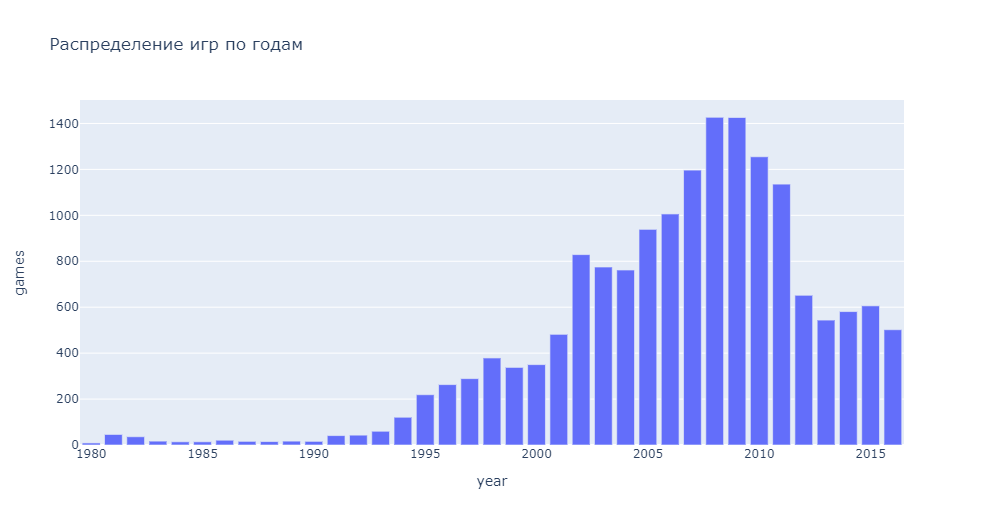

На графике хорошо видны мировые тенденции игровой индустрии. 

В начале 2000х началось золотое время компьютерных игр: на это премя пришелся переход в 3D, реалистичные эффекты и физика. Компании изучали новые возможности, эксперементировали с жанрами и сюжетами, создавали новые и новые игры.  Все это продолжалось до кризиса 2008 года. В 2009 году кризис вовсе не закончился, и 2013 стал самым тяжёлым годом для розничных продаж. Студии-разработчики игр закрывались один за одним.

Кризис остановил рост и привел к перезапуску индустрии. Компании укрупнялись и вкладывали деньги только в прибыльные проекты. Но и игры, над которыми они работали, становились сложнее и масштабнее.

Мы видим, как с 2013 года начался постепенный рост. Данные за 2016 год могут быть неполными, поэтому мы не можем исключать вероятность того, что в 2016 году рост продолжится.

### Платформы по годам

Выберем 10 платформ с самыми большими продажами за все время и построим график распределения по годам. 

In [41]:
# собираем сводную таблицу "платформа - общие продажи":
platforms_total = pd.pivot_table(data, index = 'platform', values = 'total_sales', aggfunc='sum')
platforms_total = platforms_total.reset_index().sort_values('total_sales', ascending=False)
platforms_total = platforms_total.head(10)
platforms_total

platform  total_sales
16      PS2      1233.56
28     X360       961.24
17      PS3       931.33
26      Wii       891.18
4        DS       802.78
15       PS       727.58
18      PS4       314.14
6       GBA       312.88
19      PSP       289.53
2       3DS       257.81

In [42]:
# создаем список с названием 10 самых прибыльных платформ:
list_top_10_platforms = platforms_total['platform'].unique()
list_top_10_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']
Categories (10, object): ['PS2', 'X360', 'PS3', 'Wii', ..., 'PS4', 'GBA', 'PSP', '3DS']

In [43]:
# создаем сводную таблицу "год - платформа - кол-во игр - продажи":
platforms = pd.pivot_table(data, index = ['year_of_release', 'platform'],  values= 'total_sales', aggfunc=['count', 'sum'])
platforms = platforms.reset_index()
platforms.columns = ['year', 'platform', 'games', 'sales']
platforms.head(5)

year platform  games  sales
0  1980     2600      9  11.38
1  1980      3DO      0   0.00
2  1980      3DS      0   0.00
3  1980       DC      0   0.00
4  1980       DS      0   0.00

In [44]:
# фильтруем сводную таблицу platforms по 10 топовым платформам
top_10_platforms = platforms[platforms.platform.isin(list_top_10_platforms)]
top_10_platforms = top_10_platforms[top_10_platforms['games'] > 0]
top_10_platforms.head()

year platform  games   sales
159  1985       DS      1    0.02
449  1994       PS     17    6.03
480  1995       PS     99   35.96
511  1996       PS    164   94.70
542  1997       PS    188  136.17

In [45]:
# построим график
fig = px.bar(top_10_platforms, x='year', y='sales', color='platform',
            title="Продажи по 10 топовым платформам")
fig.show()

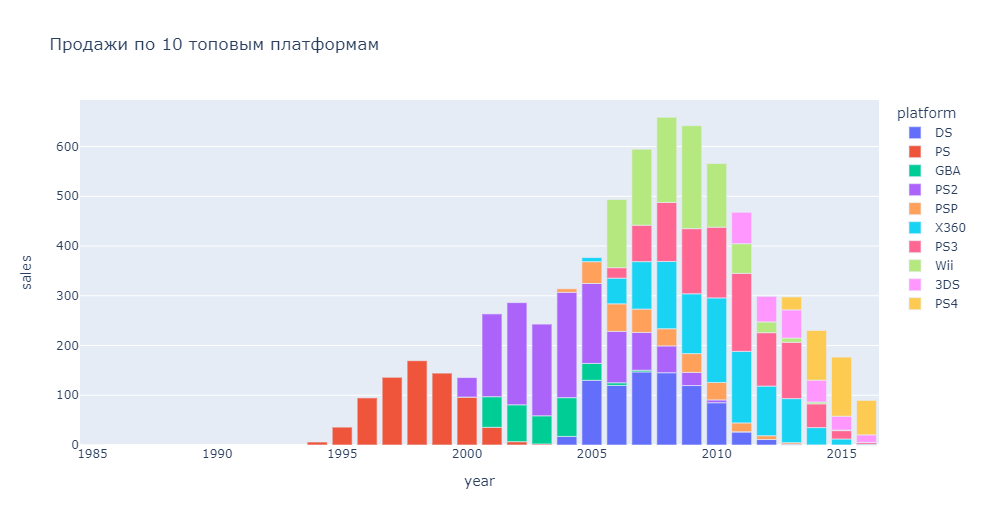

На графике показано, как менялись продажи по платформам из года в год. 

Мы видим, как на смену одним играм приходят другие. Платформы живут в среднем 10 лет: через 5-6 лет после выхода платформы на рынок появляется новая, игры на старую платформу выпускаются еще 4-5 лет и интерес к ней полностью пропадает.

Благодоря этим наблюдениям мы сможем спрогнозировать интерес к играм на 2016-2017 гг.

### Платформы по прибыли

Отфильтруем наши данные за период с 2013 по 2016 включительно и выберем самые прибыльные платформы. 

In [46]:
# отфильтруем данные по году:
actual_data = data[data['year_of_release'] > 2012]

In [47]:
# найдем самые продаваемые платформы с 2013 года:
top_platforms = pd.pivot_table(actual_data, index='platform',  values='total_sales', aggfunc = 'sum')
top_platforms.sort_values('total_sales', ascending=False).head(10)

total_sales
platform             
PS4            314.14
PS3            181.43
XOne           159.32
3DS            143.25
X360           136.80
WiiU            64.63
PC              39.43
PSV             32.99
Wii             13.66
PSP              3.50

Самые популярные платформы по выручке за 2013-2016 гг стали:
- PS4
- PS3
- XOne
- 3DS
- X360

In [48]:
# сохраним их в список 
list_top_platforms = list(top_platforms.sort_values('total_sales', ascending=False).index[:10])
print(list_top_platforms)

['PS4', 'PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC', 'PSV', 'Wii', 'PSP']


In [49]:
# отфильтруем данные по топу продаваемых игр с 2013:
top_platforms = actual_data[actual_data.platform.isin(list_top_platforms)]
top_platforms.head(5)

name platform  year_of_release         genre  \
16         Grand Theft Auto V      PS3             2013        Action   
23         Grand Theft Auto V     X360             2013        Action   
31  Call of Duty: Black Ops 3      PS4             2015       Shooter   
33        Pokemon X/Pokemon Y      3DS             2013  Role-Playing   
42         Grand Theft Auto V      PS4             2014        Action   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
16      7.02      9.09      0.98         3.96          97.0         8.2   
23      9.66      5.14      0.06         1.41          97.0         8.1   
31      6.03      5.86      0.36         2.38           NaN         NaN   
33      5.28      4.19      4.35         0.78           NaN         NaN   
42      3.96      6.31      0.38         1.97          97.0         8.3   

     rating  total_sales  
16        M        21.05  
23        M        16.27  
31  Unknown        14.63  
33  Unknown        14.60  
42        M        12.62

In [50]:
# создаем актуальную сводную таблицу "год - платформа - кол-во игр - продажи" (топ 5 платформ с 2013 года)
actual_platforms = pd.pivot_table(top_platforms, index = ['year_of_release', 'platform'],  
                                  values= 'total_sales', aggfunc=['count', 'sum'])
actual_platforms = actual_platforms.reset_index()
actual_platforms.columns = ['year', 'platform', 'games', 'sales']
actual_platforms = actual_platforms.loc[actual_platforms['games'] > 0]

actual_platforms.head()

year platform  games   sales
2   2013      3DS     91   56.57
13  2013       PC     38   12.38
17  2013      PS3    126  113.25
18  2013      PS4     16   25.99
19  2013      PSP     54    3.14

In [51]:
fig = px.line(actual_platforms, x="year", y="sales", color='platform', 
             title="График продаж по платформам")
fig.show()

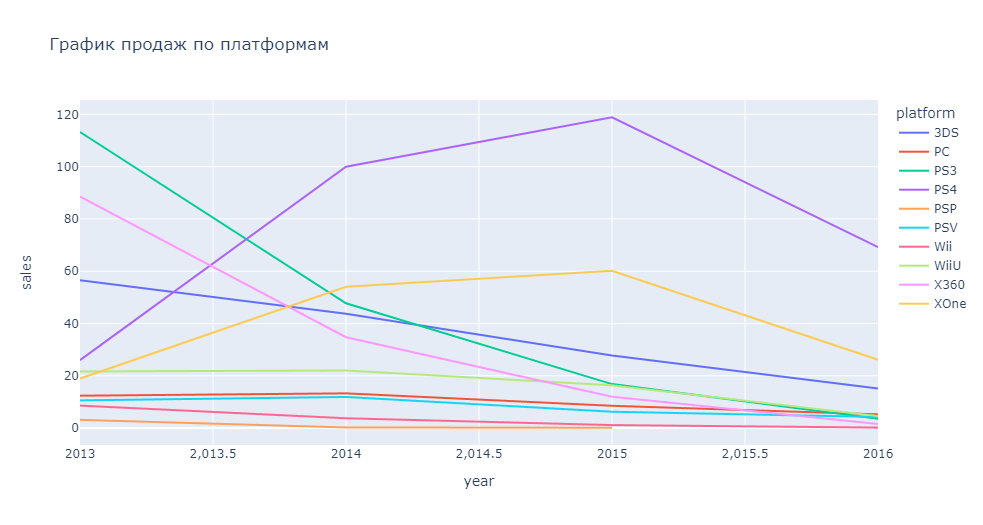

На графике мы видим снижение продаж почти по всем платформам. 

И только 2 - PS4 и XOne - были в моменте роста на 2015 год. В 2016 они бы также могли продолжать расти (платформы новые и только вышли на рынок), но данные за 2016 неполные, мы можем это только предполагать. 

### «Ящик с усами» по глобальным продажам

Напомним, что самые популярные платформы по выручке за 2013-2016 гг стали PS4, PS3, XOne, 3DS и X360. Построим для них график "Ящик с усами"

In [52]:
#list_top5_platforms = ['PS4', 'PS3', 'XOne', 'X360', '3DS']
#top5_platforms = actual_platforms[actual_platforms.platform.isin(list_top5_platforms)]

In [53]:
list_top5_platforms = ['PS4', 'PS3', 'XOne', 'X360', '3DS']
top_5_platforms = actual_data[actual_data.platform.isin(list_top5_platforms)]
# top_5_platforms.head()

In [54]:
fig = px.box(top_5_platforms, x="platform", y="total_sales", color="platform", hover_data=["name"])
fig.show()

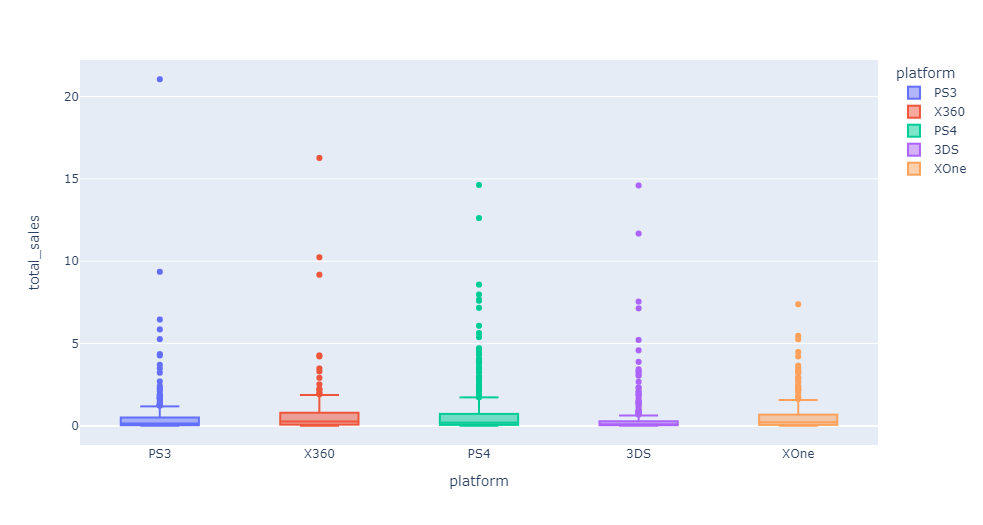

Благодаря нескольким боксплотам, мы можем быстро увидеть минимумы и максимумы, заметить, что игры на 3DS продаются меньше всего. Высота их боксплота небольшая, т.е. разница между минимальным и максимальным заработком не велика. У Х360 наоборот - "основа" боксплота, т.е. основная коробка, достаточно высокая, и нижний усик боксплота в целом находится гораздо выше, чем у остальных. 

Также мы видим большое количество выбросов по всем платформам. Их значение не стоит преуменьшать и удалять их из выборки - именно эти игры являются движущей силой всей индустрии. Продажи данных игр могут в несколько раз превышать нормальные продажи.

Несмотря на то, что одни и те же игры выпускаются сразу на несколько платформах, на каждой из них эти бестселлеры продаются неравномерно. Где-то занимают первое месте, где-то едва дотягивают до четвертого. Это надо учитывать при настройке рекламы. 

In [55]:
# ящик с усами для 10 платформ
#fig = px.box(top_platforms, x="platform", y="total_sales", color="platform", hover_data=["name"])
#fig.show()

### Отзывы и продажи

Посмотрим, как влияют на продажи внутри одной популярной платформы (PS4) отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [56]:
fig = px.scatter_matrix(actual_data[actual_data['platform'] == 'PS4'],
    dimensions=["user_score", "critic_score", "total_sales"],
    title="Матрица коррелиции между оценками пользователей, критиков и общими продажами для PS4", hover_data=["name"])
# fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.show()

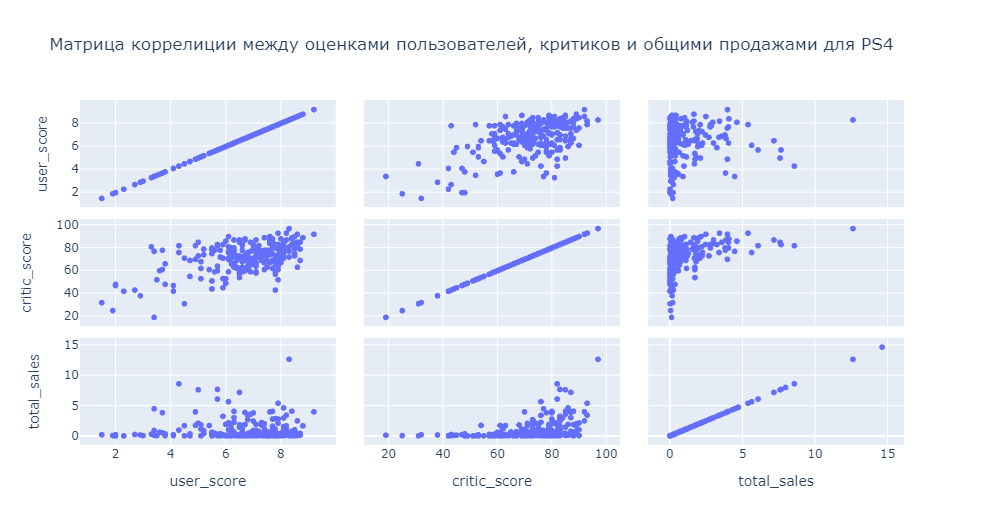

In [57]:
# найдем коэффициент корреляции
print(actual_data[actual_data['platform'] == 'PS4']
                       [['critic_score', 'user_score', 'total_sales']].corr())

              critic_score  user_score  total_sales
critic_score      1.000000    0.557654     0.406568
user_score        0.557654    1.000000    -0.031957
total_sales       0.406568   -0.031957     1.000000


Мы видим, что корреляция между отзывами критиков и отзывами пользователей есть, однако не слишком сильная. 

Также есть небольшая корреляция между оценкой критиков и общими продажами. Выходит, увеличение оценки критиков иногда сопровождается увеличениями продаж, но так бывает не всегда. 

Корреляции между оценками пользователей и объемом продаж почти нет. 

Проверим эту тенденцию на других платформах:

In [58]:
for game in list_top5_platforms: 
    if game != 'PS4':
        fig = px.scatter_matrix(actual_data[actual_data['platform'] == game],
        dimensions=["user_score", "critic_score", "total_sales"],
        title= "Матрица коррелиции между оценками пользователей, критиков и общими продажами для " + game, hover_data=["name"])
        fig.show()

              critic_score  user_score  total_sales
critic_score      1.000000    0.599920     0.334285
user_score        0.599920    1.000000     0.002394
total_sales       0.334285    0.002394     1.000000


              critic_score  user_score  total_sales
critic_score      1.000000    0.472462     0.416998
user_score        0.472462    1.000000    -0.068925
total_sales       0.416998   -0.068925     1.000000


              critic_score  user_score  total_sales
critic_score      1.000000    0.520946     0.350345
user_score        0.520946    1.000000    -0.011742
total_sales       0.350345   -0.011742     1.000000


              critic_score  user_score  total_sales
critic_score      1.000000    0.769536     0.357057
user_score        0.769536    1.000000     0.241504
total_sales       0.357057    0.241504     1.000000


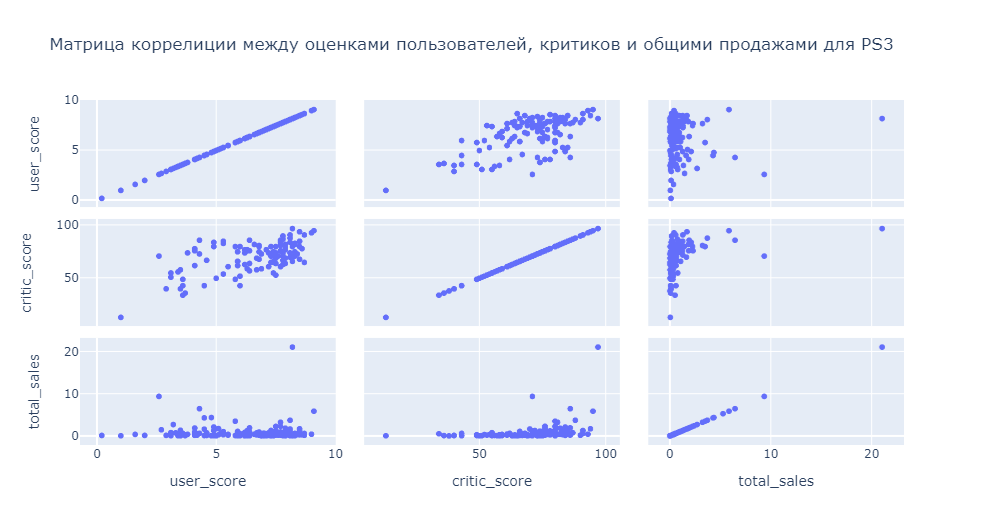

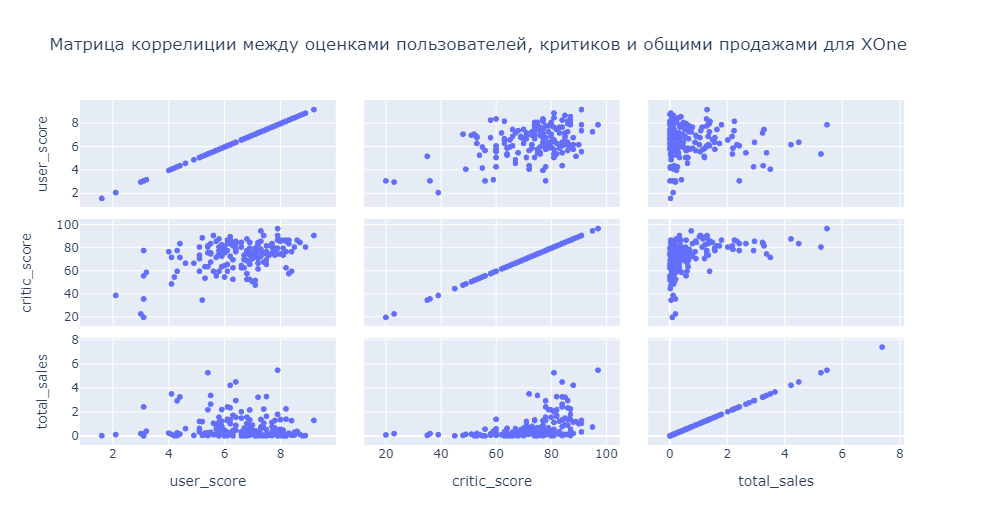

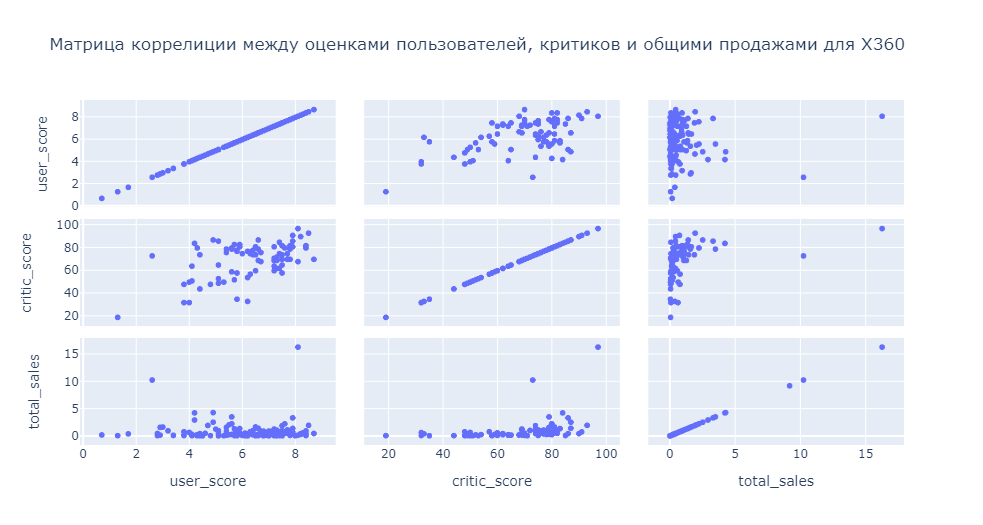

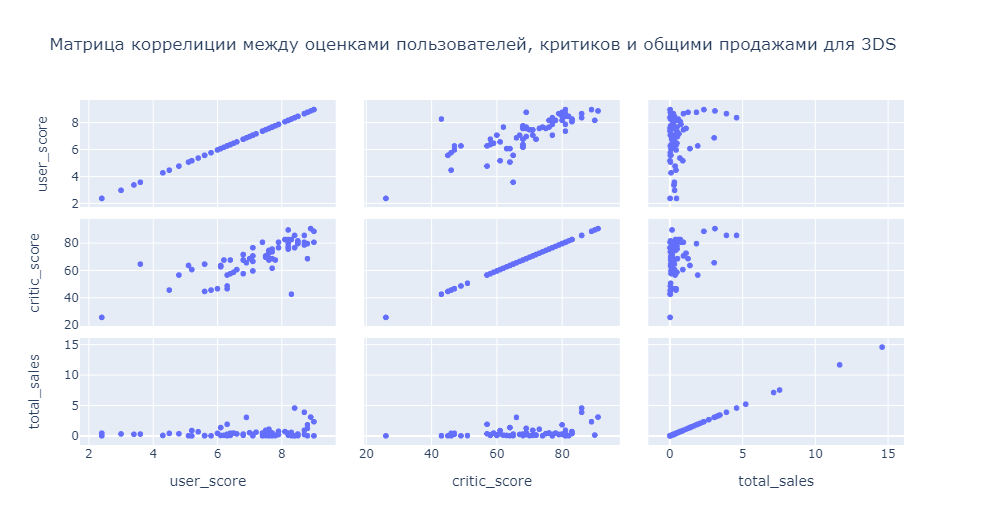

В целом, почти на всех платформах подобная ситуация: есть корреляция между оценками критиков и пользователей, небольшая корреляция между оценками критиков и продажами и почти нет корреляции между оценками пользователей и продажами.

### Игры по жанрам

Высокие продажи могут быть вызваны не успехом, а просто огромным количеством игр. Вполне могут быть жанры, где игр немного, но при этом продажи сопоставимы с продажами Экшена. Чтобы проверить это, стоит рассмотреть медианные продажи.

Определим самые прибыльные жанры по медианному значению. 

In [59]:
fig = px.box(actual_data, x="genre", y="total_sales", hover_data=["name"])
fig.show()

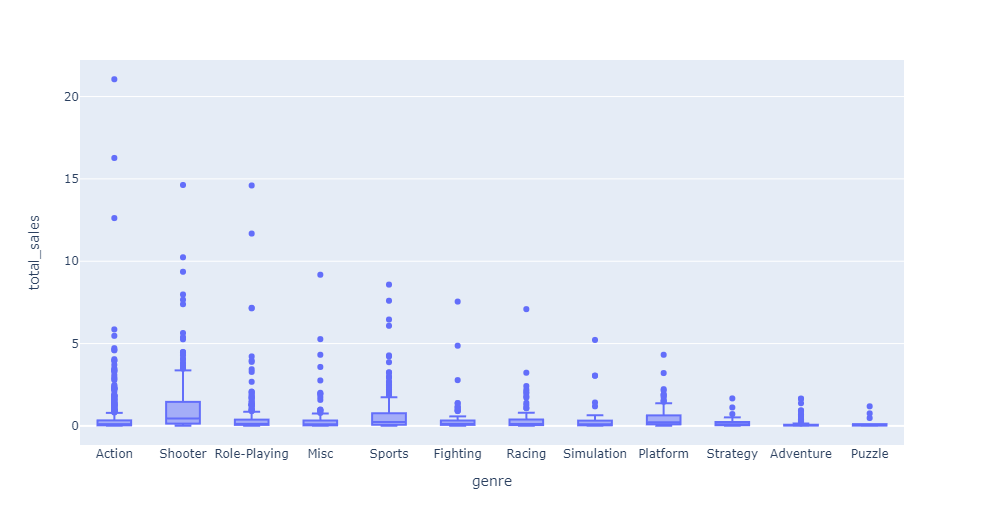

по медианным значениям выигрывает жанр Shooter, за ним в порядке убывания Sports, Platform, Role-Playing, Fighting.

### Вывод

Проанализировав данные видеоигр мы пришли к выводу, что для прогноза продаж на 2017 год нам необходимы только данные с 2013 года. Именно с этого момента начался рост продаж после кризиса 2008 года. 

Мы выяснили, что игровые платформы живут в среднем 10 лет: через 5-6 лет после выхода на рынок появляется новая платформа, игры на старую выпускаются еще 4-5 лет и интерес к ней полностью пропадает. Благодоря этим наблюдениям мы сможем спрогнозировать интерес к играм на 2016-2017 гг.

К 2016 году шло снижение продаж почти по всем платформам. И только две - PS4 и XOne - были в моменте роста по состаянию на 2015 год. Мы выяснили, что платформы новые, только вышли на рынок и еще не достигли своего максимума продаж. Поэтому в 2016-2017 годах они бы также могли продолжить рост. 

Также мы увидели что бестселлеры у каждой платформы свои, и это необходимо учитывать при настройке рекламы. 

Оказалось, что отзывы критиков имеют корреляцию с продажами, а вот отзывы пользователей на продажи не влияют. 

Самые продаваемые жанры (в порядке убывания):
1. Action
2. Shooter
3. Sports
4. Role-Playing

Лучше не ставить на Strategy и Puzzle жанры. 

## Портрет пользователя по регионам

### Самые популярные платформы (топ-5)

In [60]:
region_platforms = pd.pivot_table(actual_data, index=['platform'], 
                                  values=['na_sales', 'eu_sales', 'jp_sales', 'total_sales'], aggfunc='sum')
region_platforms = region_platforms.reset_index()
region_platforms = region_platforms.loc[region_platforms['total_sales'] > 0]
region_platforms

platform  eu_sales  jp_sales  na_sales  total_sales
2       3DS     30.96     67.81     38.20       143.25
4        DS      0.85      0.00      0.57         1.54
13       PC     25.36      0.00     11.11        39.43
17      PS3     67.81     23.35     63.50       181.43
18      PS4    141.09     15.96    108.74       314.14
19      PSP      0.17      3.29      0.00         3.50
20      PSV      6.10     18.59      5.04        32.99
26      Wii      5.93      0.05      6.56        13.66
27     WiiU     19.85     10.88     29.21        64.63
28     X360     42.52      0.51     81.66       136.80
30     XOne     51.59      0.34     93.12       159.32

In [61]:
labels = region_platforms['platform']

fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Европа', 'Япония', 'Северная Америка'])
fig.add_trace(go.Pie(labels=labels, values=region_platforms['eu_sales'], name="Европа", textinfo='label+percent'),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=region_platforms['jp_sales'], name="Япония", textinfo='label+percent'),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=region_platforms['na_sales'], name="Северная Америка", 
                     textinfo='label+percent'),
              1, 3)
fig.update_layout(title_text="Продажи игр по платформам")

fig.show()

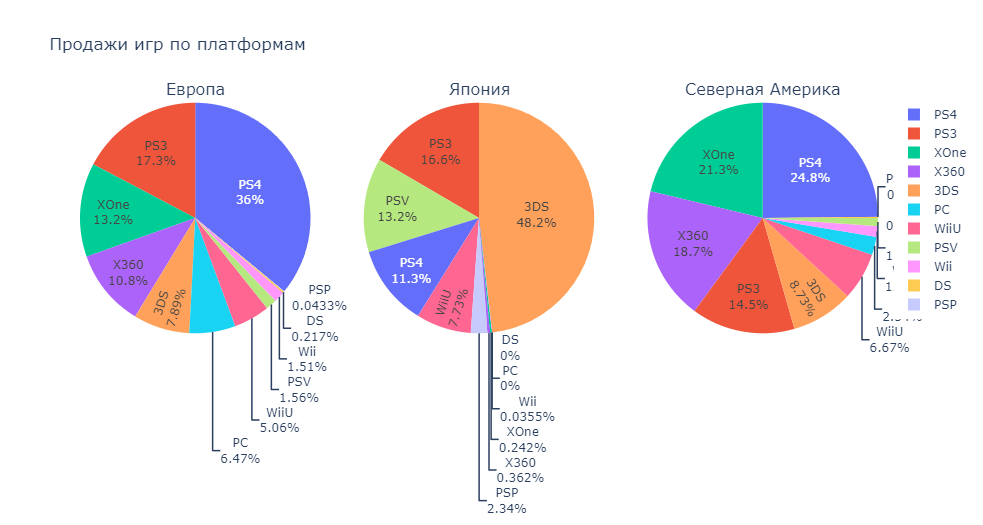

На диаграмах видно, что продажи игр на разные платформы не одинаковы в разных регионах. 

Топ 5 игр по регионам:
- Европа: 
    - PS4
    - PS3
    - XOne
    - X360
    - 3DS
- Япония:
    - 3DS 
    - PS3
    - PSV
    - PS4
    - WiiU
- Северная Америка:
    - PS4
    - XOne
    - X360
    - PS3
    - 3DS

Так например, в Японии популярны платформы местных производителей, спросом не пользуются американские XOne и X360. Более того, имено в Японии пользуются большим спросом портативные системы, такие как 3DS(занимают 62,8% от всех продаж), PSV и WiiU.

В Северной Америке продукты Microsoft уже пользуются бОльшей популярностью, суммарно XOne X360 занимают почти половину рынка, но на первом месте по продажам все равно стоит PS4. 3DS занимает последнее место.

В Европе больше предпочитают продукты Sony. 3DS занимает последнее место.

### Самые популярные жанры (топ-5)

In [62]:
region_genre = pd.pivot_table(actual_data, index='genre', values=['eu_sales', 'jp_sales', 'na_sales'],
                                        aggfunc='sum')
region_genre = region_genre.reset_index()
region_genre

genre  eu_sales  jp_sales  na_sales
0         Action    118.13     40.49    126.05
1      Adventure      8.25      5.82      7.14
2       Fighting      8.55      7.65     15.55
3           Misc     20.04      9.20     27.49
4       Platform     15.58      4.79     18.14
5         Puzzle      1.00      1.18      0.83
6         Racing     20.19      2.30     12.96
7   Role-Playing     36.97     51.04     46.40
8        Shooter     87.86      6.61    109.74
9     Simulation     10.92      4.52      4.86
10        Sports     60.52      5.41     65.27
11      Strategy      4.22      1.77      3.28

In [63]:
labels = region_genre['genre']

fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Европа', 'Япония', 'Северная Америка'])
fig.add_trace(go.Pie(labels=labels, values=region_genre['eu_sales'], name="Европа"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=region_genre['jp_sales'], name="Япония"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=region_genre['na_sales'], name="Северная Америка"),
              1, 3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text="Продажи игр по жанрам")

fig.show()

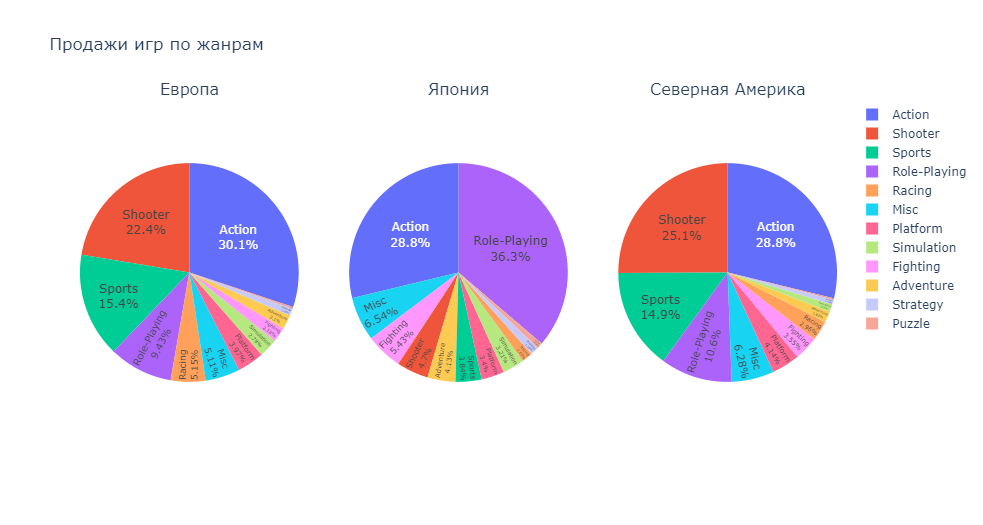

Топ 5 жанров по регионам:
- Европа: 
    - Action 
    - Shooter
    - Sports
    - Role-Playing
    - Racing
- Япония: 
    - Role-Playing
    - Action
    - Misc 
    - Fighting 
    - Shooter
- Северная Америка: 
    - Action
    - Shooter
    - Sports
    - Role-Playing 
    - Misc

Американцы и Европейцы в целом, любят похожие жанры в играх. На их фоне очень отличаются Японцы: почти 40% рынка занимают игры жанра Role-Playing(Европе и Америке их доля не привышает 10-11%)

### Влияние рейтинга ESRB на продажи

In [64]:
region_rating = pd.pivot_table(actual_data, index='rating', values=['eu_sales', 'jp_sales', 'na_sales'],
                                        aggfunc='sum')
region_rating = region_rating.reset_index()
region_rating = region_rating.loc[region_rating['rating'] != 'Unknown']
region_rating

rating  eu_sales  jp_sales  na_sales
0      E     83.87     15.18     79.10
1   E10+     44.85      5.99     55.86
2      M    148.16     14.26    167.63
3      T     42.34     21.75     50.48

In [65]:
labels = region_rating['rating']

fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Европа', 'Япония', 'Северная Америка'])
fig.add_trace(go.Pie(labels=labels, values=region_rating['eu_sales'], name="Европа"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=region_rating['jp_sales'], name="Япония"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=region_rating['na_sales'], name="Северная Америка"),
              1, 3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text="Продажи игр по рейтингу")

fig.show()

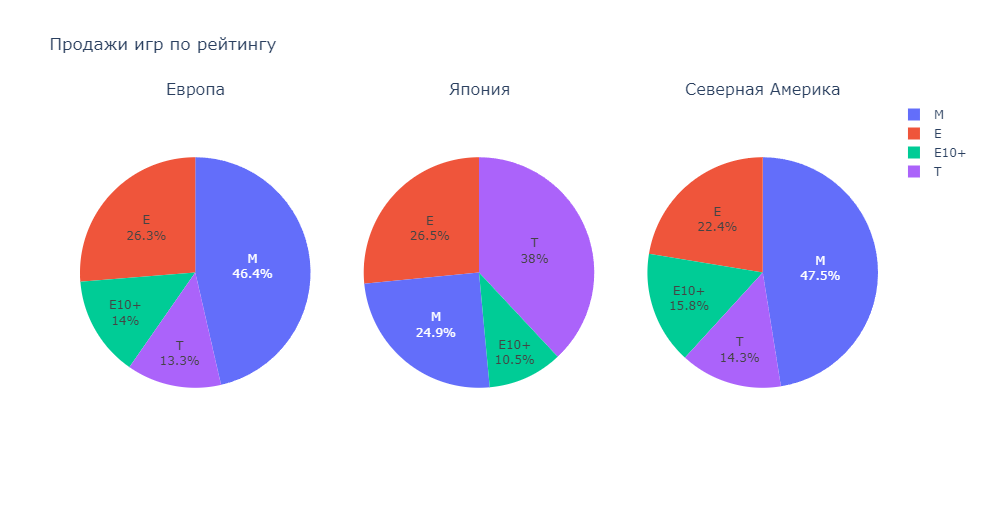

Напомним значения рейтингов:
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам» от 13 лет и старше
- «M» («Mature») — «Для взрослых» от 17 лет и старше

Мы видим, что в Америке и Европе ситуация с продажами игр по возрастным рейтингам примерно одинаковая, половина игр выпускается для лиц старше 17 лет. В Японии на первом месте (37,6%) идут игры с рейтингом "Т" - для лиц старше 13 лет, а рейтинг "М" - на втором месте (30,7%). 

### Вывод

Европа:
- Платформы: PS4, PS3, XOne, X360, 3DS
- Жанры: Action, Shooter, Sports, Role-Playing, Racing
- Рейтинг: M - 46.4%, E - 26.3%, E10+ - 14%, T - 13%
В Европе больше предпочитают продукты Sony. 3DS занимает последнее место.

Япония:
- Платформы: 3DS, PS3, PSV, PS4, WiiU
- Жанры: Role-Playing, Action, Misc, Fighting, Shooter
- Рейтинг: T - 38%, E - 26.5%, M - 24,9%, E10+ - 10.5%

Так например, в Японии популярны платформы местных производителей, спросом не пользуются американские XOne и X360. Более того, имено в Японии пользуются большим спросом портативные системы, такие как 3DS(занимают 62,8% от всех продаж), PSV и WiiU. Почти 40% рынка занимают игры жанра Role-Playing(Европе и Америке их доля не привышает 10-11%)

В Японии на первом месте (37,6%) идут игры с рейтингом "Т" - для лиц старше 13 лет, а рейтинг "М" - на втором месте (30,7%). И это не удивительно - больше половины продаж в Японии приходится на портативную 3DS, а ей больше всего интересуются молодые люди. 

Северная Америка:
- Предпочитают PS4, XOne, X360, PS3, 3DS
- Жанры: Action, Shooter, Sports, Role-Playing, Misc
- Рейтинг: M - 47.5%, E - 22.4%, E10+ - 15.8%, T - 14.3%


В Северной Америке продукты Microsoft уже пользуются бОльшей популярностью, суммарно XOne X360 занимают почти половину рынка, но на первом месте по продажам все равно стоит PS4. 3DS занимает последнее место. В Америке и Европе ситуация с продажами игр по возрастным рейтингам примерно одинаковая, половина игр выпускается для лиц старше 17 лет.

## Проверим гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC

Нулевая гипотеза (H0): Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтерантивная гипотеза (H1): Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Разделим наши данные на два фрейма - для XOne и PC:

In [66]:
XOne_score = actual_data.query('platform == "XOne"')['user_score'].dropna()
XOne_score.describe()

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

In [67]:
PC_score = actual_data.query('platform == "PC"')['user_score'].dropna()
PC_score.describe()

count    155.000000
mean       6.269677
std        1.742381
min        1.400000
25%        5.300000
50%        6.800000
75%        7.600000
max        9.300000
Name: user_score, dtype: float64

In [68]:
alpha = .05

results = st.ttest_ind(XOne_score, PC_score)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Для оценки гипотезы мы применили тест Стюдента и получили ответ "Не получилось отвергнуть нулевую гипотезу".  Это значит, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

### Средние пользовательские рейтинги жанров Action и Sports

Нулевая гипотеза (H0): Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.

Альтерантивная гипотеза (H1): Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [69]:
action_score = actual_data.query('genre == "Action"')['user_score'].dropna()
action_score.describe()

count    389.000000
mean       6.837532
std        1.330173
min        2.000000
25%        6.300000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

In [70]:
sports_score = actual_data.query('genre == "Sports"')['user_score'].dropna()
sports_score.describe()

count    160.000000
mean       5.238125
std        1.783427
min        0.200000
25%        4.100000
50%        5.500000
75%        6.500000
max        8.800000
Name: user_score, dtype: float64

In [71]:
alpha = .05

results = st.ttest_ind(action_score, sports_score)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Для оценки гипотезы мы применили тест Стюдента и получили ответ "Отвергаем нулевую гипотезу".  Это значит, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

## Вывод

В ходе исследования мы выполнили предобработку данных:
- привели названия столбцов к нижнему регистру;
- нашли закономерности в пропусках, обработали их, укрупнили группы. 
- преобразовали типы данных
- проверили на дубликаты и удалили их
- добавили информацию об общах продажах

Проанализировав данные видеоигр мы пришли к выводу, что для прогноза продаж на 2017 год нам необходимы только данные с 2013 года. Именно с этого момента начался рост продаж после кризиса 2008 года. 

Мы выяснили, что игровые платформы живут в среднем 10 лет: через 5-6 лет после выхода на рынок появляется новая платформа, игры на старую выпускаются еще 4-5 лет и интерес к ней полностью пропадает. Благодоря этим наблюдениям мы сможем спрогнозировать интерес к играм на 2016-2017 гг.

К 2016 году шло снижение продаж почти по всем платформам. И только две - PS4 и XOne - были в моменте роста по состаянию на 2015 год. Мы выяснили, что платформы новые, только вышли на рынок и еще не достигли своего максимума продаж. Поэтому в 2016-2017 годах они бы также могли продолжить рост. 

Также мы увидели что бестселлеры у каждой платформы свои, и это необходимо учитывать при настройке рекламы. 

Оказалось, что отзывы критиков имеют корреляцию с продажами, а вот отзывы пользователей на продажи не влияют. 

Самые продаваемые жанры (в порядке убывания):
1. Action
2. Shooter
3. Sports
4. Role-Playing

Лучше не ставить на Strategy и Puzzle жанры.  

### Портрет 
#### Европа:

- Платформы: PS4, PS3, XOne, X360, 3DS
- Жанры: Action, Shooter, Sports, Role-Playing, Racing
- Рейтинг: M - 46.4%, E - 26.3%, E10+ - 14%, T - 13% 

В Европе больше предпочитают продукты Sony. 3DS занимает последнее место.
#### Япония:

- Платформы: 3DS, PS3, PSV, PS4, WiiU
- Жанры: Role-Playing, Action, Misc, Fighting, Shooter
- Рейтинг: T - 38%, E - 26.5%, M - 24,9%, E10+ - 10.5%

Так например, в Японии популярны платформы местных производителей, спросом не пользуются американские XOne и X360. Более того, имено в Японии пользуются большим спросом портативные системы, такие как 3DS(занимают 62,8% от всех продаж), PSV и WiiU. Почти 40% рынка занимают игры жанра Role-Playing(Европе и Америке их доля не привышает 10-11%)

В Японии на первом месте (37,6%) идут игры с рейтингом "Т" - для лиц старше 13 лет, а рейтинг "М" - на втором месте (30,7%). И это не удивительно - больше половины продаж в Японии приходится на портативную 3DS, а ей больше всего интересуются молодые люди.

#### Северная Америка:

- Предпочитают PS4, XOne, X360, PS3, 3DS
- Жанры: Action, Shooter, Sports, Role-Playing, Misc
- Рейтинг: M - 47.5%, E - 22.4%, E10+ - 15.8%, T - 14.3%

В Северной Америке продукты Microsoft уже пользуются бОльшей популярностью, суммарно XOne X360 занимают почти половину рынка, но на первом месте по продажам все равно стоит PS4. 3DS занимает последнее место. В Америке и Европе ситуация с продажами игр по возрастным рейтингам примерно одинаковая, половина игр выпускается для лиц старше 17 лет.